Dataset link - 

https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset

In [3]:
# # import required libraries after code execution state reset
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer



In [4]:
# Load the dataset 
df = pd.read_csv("Twitter_Data.csv") 

# Show basic structure
print("Shape of dataset:", df.shape)
print("Column names:", df.columns.tolist())

# View first few rows
df.head()

Shape of dataset: (162980, 2)
Column names: ['clean_text', 'category']


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


We have two columns in our dataset. first columns has twitter text, and the next column is the category of sentiment negative(-1), neutral(0), and positive(+1). We have total 162980 tweets in total. 

## Handle Missing Values and Duplicates.

In [5]:
print("Before cleaning total rows:", df.shape[0])
# Drop rows where 'clean_text' is missing
df = df.dropna(subset=["clean_text"])

# Drop duplicate tweets (if any)
df = df.drop_duplicates(subset=["clean_text"])

# Check the result
print("After cleaning:")
print("Remaining rows:", df.shape[0])



Before cleaning total rows: 162980
After cleaning:
Remaining rows: 162976


In [6]:
df = df.sample(n=5000, random_state=42).reset_index(drop=True)


## Clean the tweets 

In [7]:
#Clean the tweets
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+|@\w+|#\w+", "", text)  # Remove URLs, mentions, hashtags
    text = re.sub(r"[^a-z\s]", "", text)  # Remove punctuation and numbers
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)


In [8]:
#Apply preprocessing and cleaning
df["processed_text"] = df["clean_text"].astype(str).apply(preprocess_text)
df["processed_text"].head()


0    bjp criminal modi lead party gugrat crime need...
1    dont think believe commentsthey seem comment l...
2    best anything good modi take credit anything b...
3    fell trap social medium run modi bashing seems...
4    congratulation sir thank making vibrant northe...
Name: processed_text, dtype: object

## Exploratory Data Analysis (EDA)

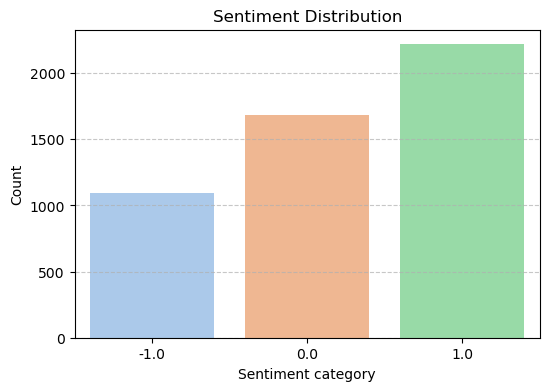

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='category', data=df, palette='pastel')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment category')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Words cloud by sentiment 

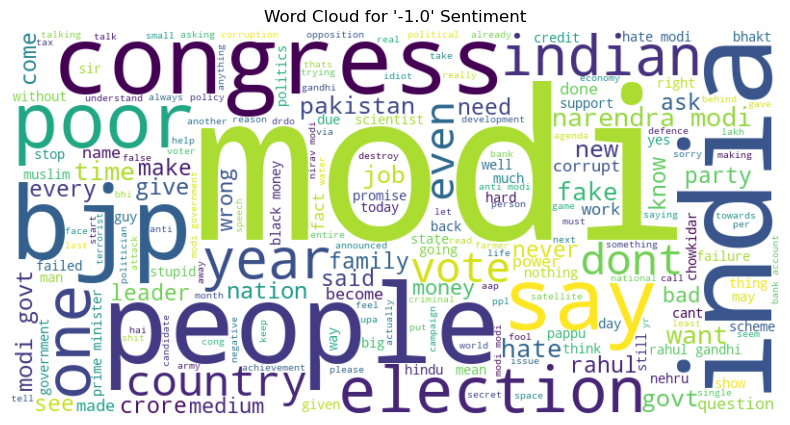

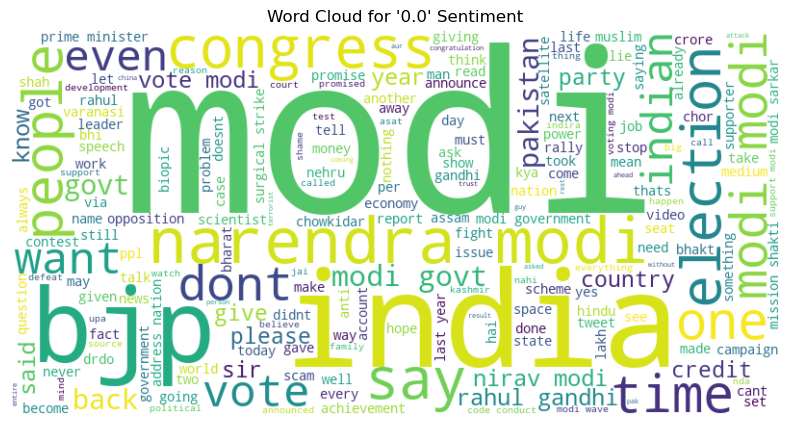

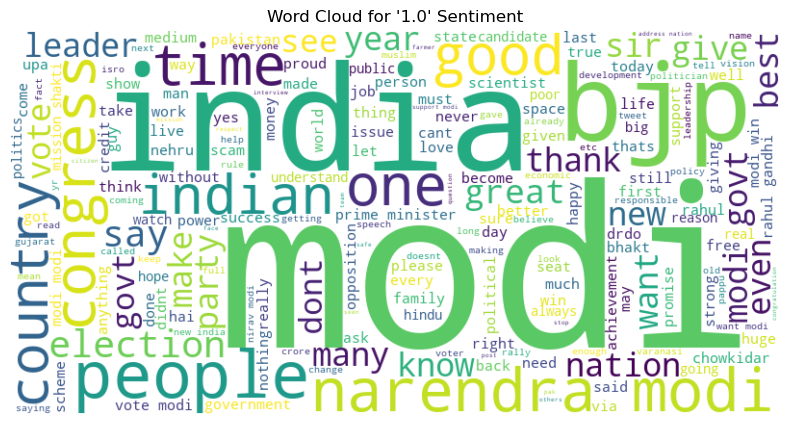

In [10]:
from wordcloud import WordCloud

sentiments = df['category'].dropna().unique()

for sentiment in sentiments:
    # Filter and combine text
    text = " ".join(df[df['category'] == sentiment]['processed_text'].dropna().astype(str))
    
    if len(text.strip()) < 1:
        print(f"Skipping '{sentiment}' sentiment – no text available.")
        continue
    
    # Generate and display word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for '{sentiment}' Sentiment")
    plt.show()


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words='english')

# Apply to your processed tweets
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

# Check shape and feature names
print("TF-IDF matrix shape:", tfidf_matrix.shape)
print("Sample words:", tfidf_vectorizer.get_feature_names_out()[:10])


TF-IDF matrix shape: (5000, 2052)
Sample words: ['aap' 'aayog' 'abdullah' 'abhi' 'abhinandan' 'ability' 'able' 'abroad'
 'absolute' 'absolutely']


## Extract Top TF-IDF Scores

In [33]:
import numpy as np

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Sum TF-IDF scores for each word across all documents
tfidf_sums = np.asarray(tfidf_matrix.sum(axis=0)).flatten()

# Create a DataFrame of words and their total TF-IDF score
tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf': tfidf_sums})

# Sort by score
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False)
tfidf_df.head(10)


,word,tfidf
1202,modi,392.229381
917,india,151.099171
207,bjp,85.986694
1233,narendra,80.168035
1339,people,79.754445
1067,like,79.596675
599,election,76.651319
1964,vote,73.958904
383,congress,70.756824
1610,say,63.956078


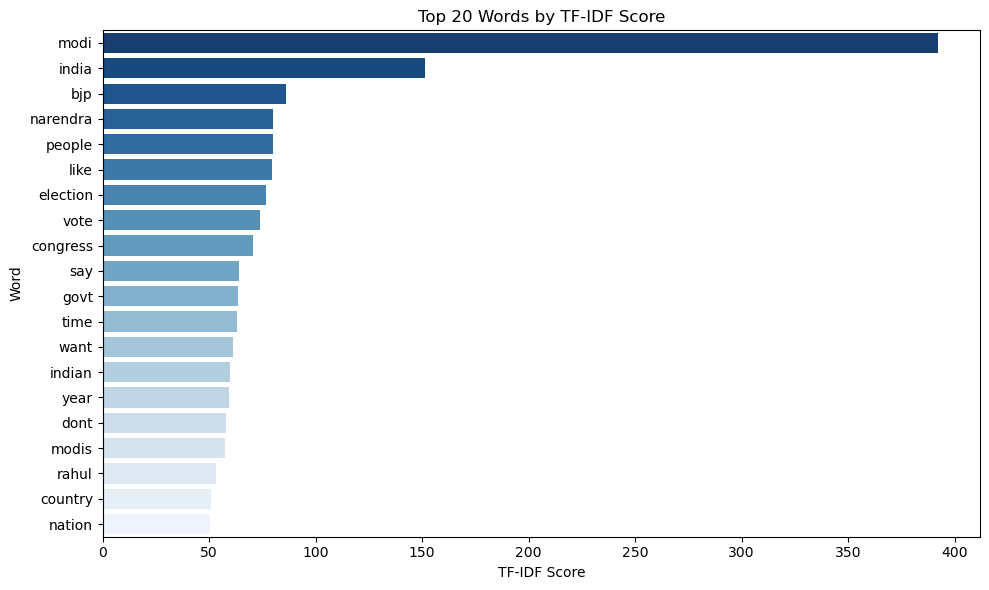

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot top 20 words
top_n = 20
plt.figure(figsize=(10, 6))
sns.barplot(x='tfidf', y='word', data=tfidf_df.head(top_n), palette='Blues_r')
plt.title(f'Top {top_n} Words by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.tight_layout()
plt.show()


In [34]:
#implement Word2Vec

from gensim.models import Word2Vec

# Tokenize processed text
tokenized_sentences = df['processed_text'].dropna().astype(str).apply(lambda x: x.split()).tolist()

# CBOW model (sg=0)
cbow_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=0  # CBOW
)

# Skip-gram model (sg=1)
skipgram_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1  # Skip-gram
)

# Example output
print("CBOW:", cbow_model.wv.most_similar("modi", topn=5))
print("Skip-gram:", skipgram_model.wv.most_similar("modi", topn=5))


CBOW: [('one', 0.9997065663337708), ('indian', 0.9996676445007324), ('said', 0.9996536374092102), ('today', 0.9996469616889954), ('please', 0.9996361136436462)]
Skip-gram: [('interview', 0.9802535772323608), ('pradesh', 0.978760302066803), ('campaign', 0.9756515026092529), ('march', 0.9729951024055481), ('honorable', 0.9729675650596619)]


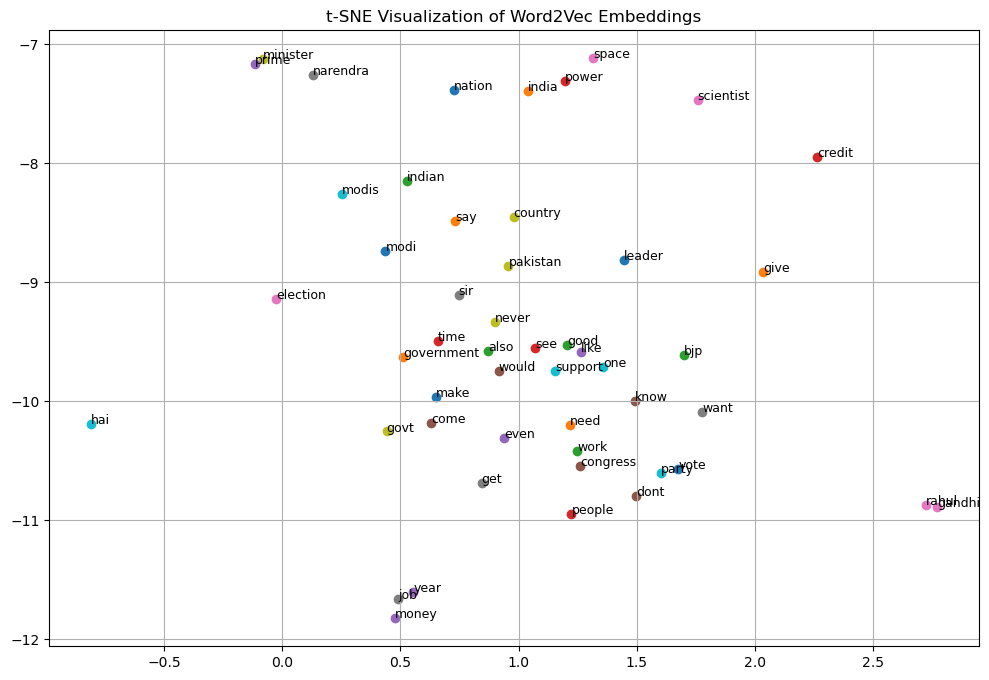

In [17]:
from sklearn.manifold import TSNE

# Select top 50 frequent words from the model
top_n = 50  
words = list(w2v_model.wv.key_to_index.keys())[:top_n]

# Get corresponding vectors and convert to NumPy array
word_vectors = np.array([w2v_model.wv[word] for word in words])

# Set perplexity lower than number of words
perplexity = min(30, len(words) - 1)

# Apply t-SNE to reduce dimensions
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, init='pca', learning_rate='auto')
word_vec_2d = tsne.fit_transform(word_vectors)

# Plot
plt.figure(figsize=(12, 8))
for i, word in enumerate(words):
    plt.scatter(word_vec_2d[i, 0], word_vec_2d[i, 1])
    plt.annotate(word, xy=(word_vec_2d[i, 0], word_vec_2d[i, 1]), fontsize=9)
plt.title("t-SNE Visualization of Word2Vec Embeddings")
plt.grid(True)
plt.show()


To explore the semantic relationships learned by Word2Vec, a t-SNE visualization was generated for the top 50 most frequent words. The plot revealed meaningful clusters, for instance, political figures such as "modi", "rahul", "gandhi", and "narendra" appeared near related terms like "minister", "election", "party", and "bjp". Similarly, action-related words such as "make", "get", "work", and "done" grouped together. This spatial arrangement confirms that the embeddings effectively captured contextual associations from the tweet corpus.

# Model training and fitting

In [36]:

#Fit and run the LDA model
from sklearn.decomposition import LatentDirichletAllocation

# Bag-of-Words vectorization
count_vectorizer = CountVectorizer(max_df=0.95, min_df=10, stop_words='english')
doc_term_matrix = count_vectorizer.fit_transform(df['processed_text'])

# Initialize and train the LDA model
num_topics = 10  # Adjust as needed
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(doc_term_matrix)

# Print top words per topic
feature_names = count_vectorizer.get_feature_names_out()
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic #{topic_idx + 1}: {top_words}")

print_top_words(lda_model, feature_names)

# Assign topics to each document
topic_distributions = lda_model.transform(doc_term_matrix)
df['lda_dominant_topic'] = topic_distributions.argmax(axis=1)
df[['processed_text', 'lda_dominant_topic']].head()


Topic #1: ['modi', 'govt', 'india', 'new', 'campaign', 'like', 'time', 'bjp', 'poll', 'nation']
Topic #2: ['modi', 'year', 'vote', 'india', 'nation', 'crore', 'time', 'money', 'address', 'work']
Topic #3: ['modi', 'india', 'space', 'narendra', 'power', 'satellite', 'missile', 'minister', 'prime', 'live']
Topic #4: ['modi', 'anti', 'hindu', 'muslim', 'people', 'pakistan', 'say', 'hate', 'scam', 'sir']
Topic #5: ['modi', 'rahul', 'gandhi', 'minister', 'prime', 'election', 'modis', 'indian', 'narendra', 'speech']
Topic #6: ['modi', 'bjp', 'dont', 'vote', 'congress', 'party', 'want', 'think', 'like', 'rahul']
Topic #7: ['modi', 'india', 'credit', 'scientist', 'jai', 'drdo', 'best', 'nehru', 'world', 'leader']
Topic #8: ['modi', 'like', 'government', 'country', 'job', 'people', 'bjp', 'fake', 'farmer', 'going']
Topic #9: ['modi', 'people', 'dont', 'nirav', 'question', 'like', 'man', 'court', 'ask', 'congress']
Topic #10: ['modi', 'election', 'india', 'strike', 'govt', 'rally', 'shah', 'upa'

,processed_text,lda_dominant_topic
0,bjp criminal modi lead party gugrat crime need...,5
1,dont think believe commentsthey seem comment l...,5
2,best anything good modi take credit anything b...,6
3,fell trap social medium run modi bashing seems...,1
4,congratulation sir thank making vibrant northe...,6


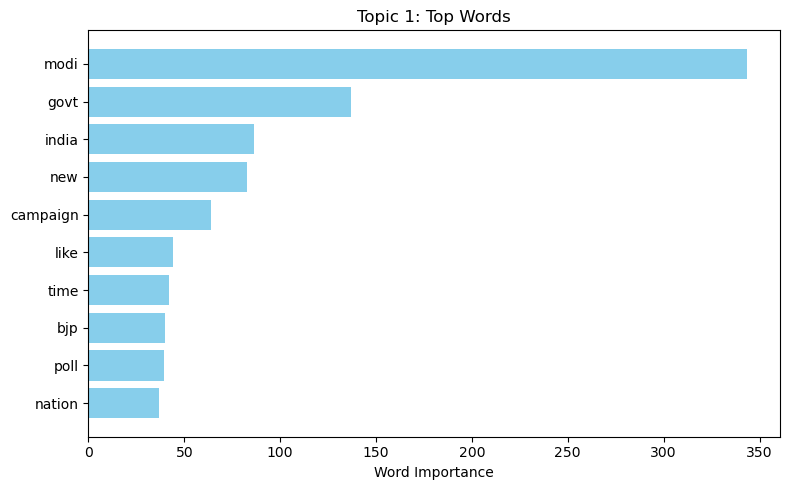

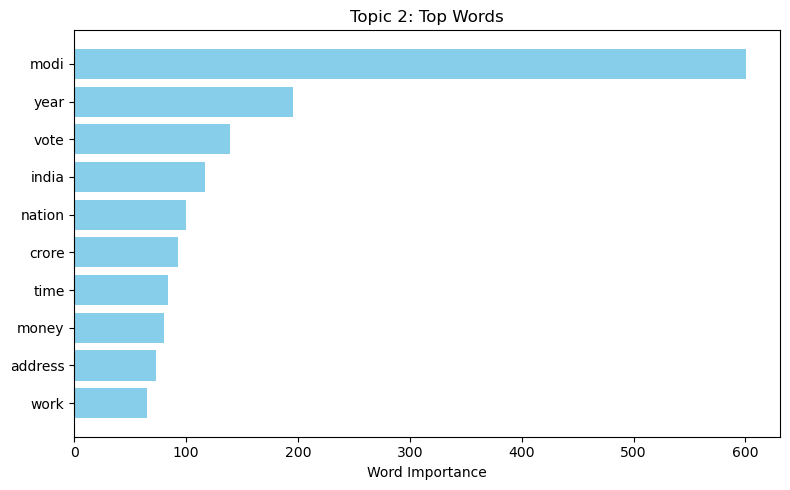

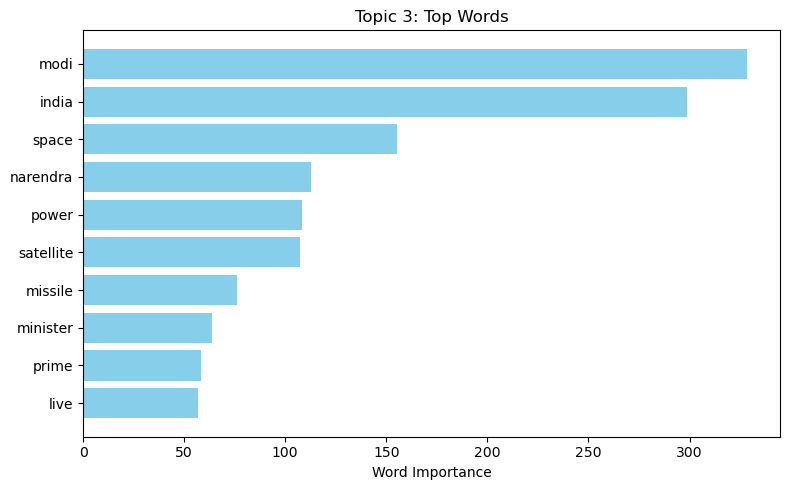

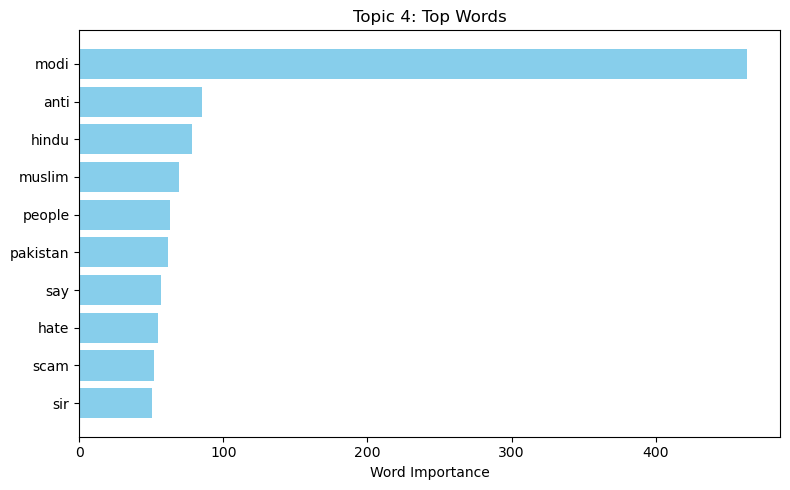

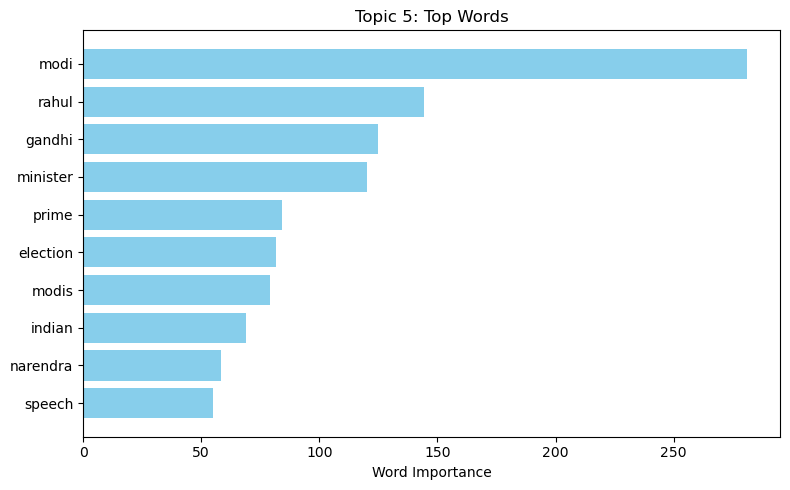

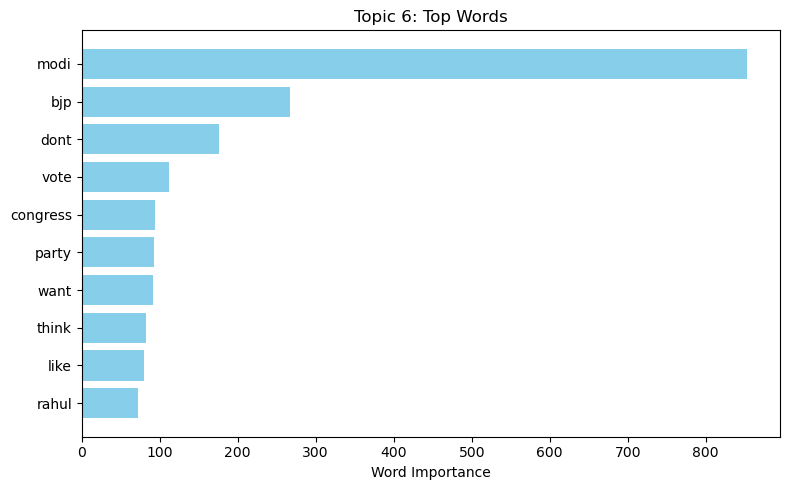

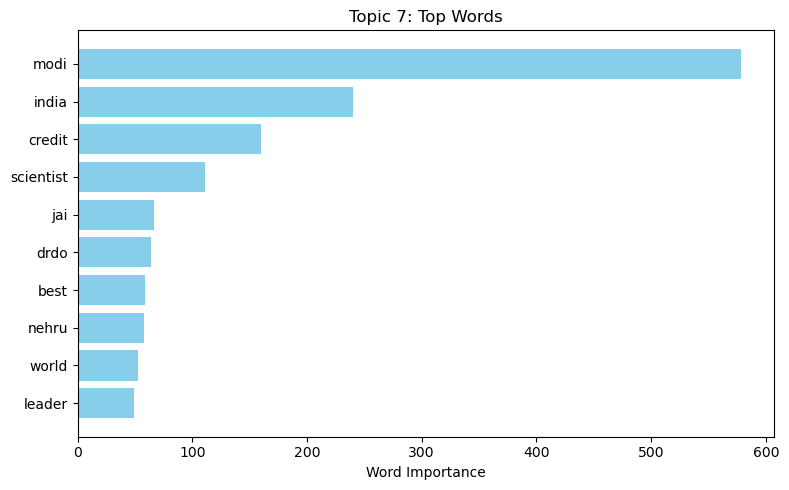

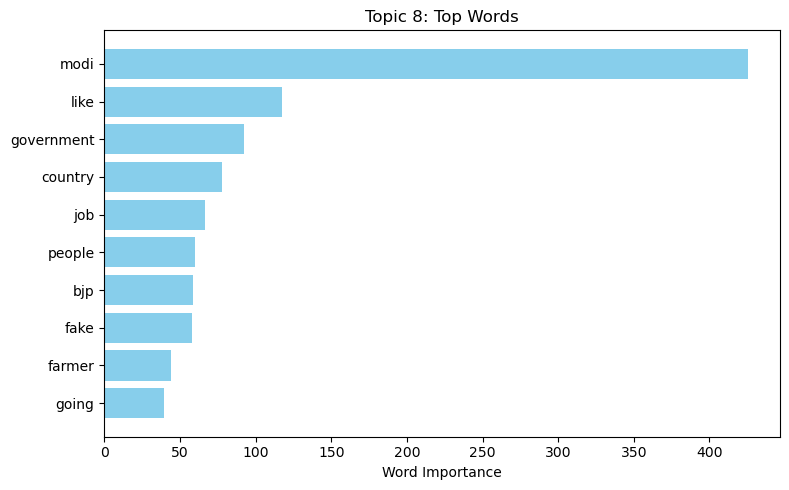

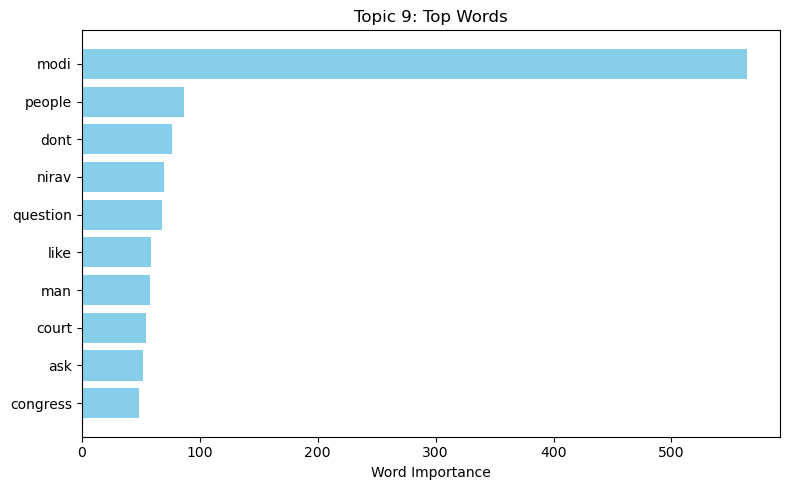

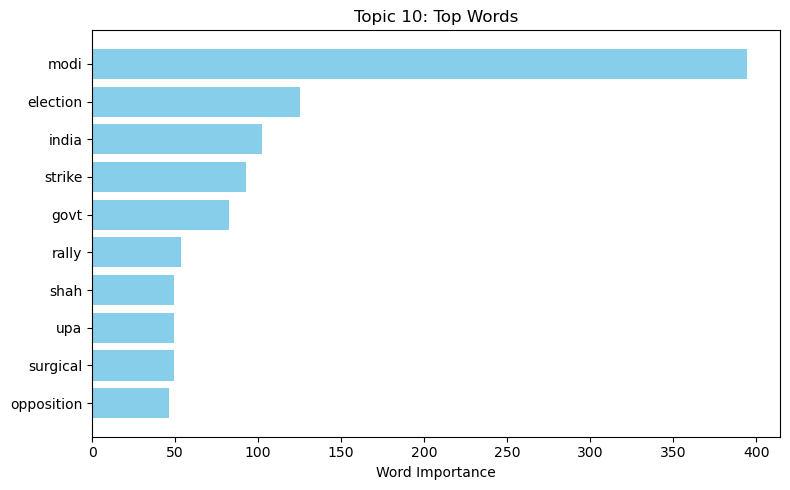

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to extract top words for each topic
def get_topic_words(lda_model, feature_names, n_top_words=10):
    topic_word_dict = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_word_dict[f'Topic {topic_idx + 1}'] = top_words
    return topic_word_dict

# Extract and format top words
feature_names = count_vectorizer.get_feature_names_out()
topics = get_topic_words(lda_model, feature_names, n_top_words=10)

# Plot each topic's top words as a bar chart
for topic, words in topics.items():
    scores = lda_model.components_[int(topic.split()[1]) - 1]
    word_scores = [scores[feature_names.tolist().index(word)] for word in words]
    
    plt.figure(figsize=(8, 5))
    plt.barh(words[::-1], word_scores[::-1], color='skyblue')
    plt.title(f"{topic}: Top Words")
    plt.xlabel("Word Importance")
    plt.tight_layout()
    plt.show()


## Model Evaluation

# Coherence Score (using Gensim)
This measures how semantically similar the top words in each topic are.

In [21]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Step 1: Tokenize your documents
tokenized_texts = df['processed_text'].dropna().astype(str).apply(lambda x: x.split()).tolist()

# Step 2: Create Gensim dictionary and corpus (for CoherenceModel)
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Step 3: Extract top words for each topic from sklearn LDA
def get_sklearn_topics(lda_model, feature_names, top_n=10):
    topic_list = []
    for topic_weights in lda_model.components_:
        top_words = [feature_names[i] for i in topic_weights.argsort()[:-top_n - 1:-1]]
        topic_list.append(top_words)
    return topic_list

topics = get_sklearn_topics(lda_model, feature_names, top_n=10)

# Step 4: Compute Coherence Score using Gensim's CoherenceModel
coherence_model = CoherenceModel(
    topics=topics,
    texts=tokenized_texts,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print("Coherence Score (sklearn LDA):", round(coherence_score, 4))


Coherence Score (sklearn LDA): 0.4053


The LDA model achieved a coherence score of 0.4053, indicating moderate semantic similarity within topic keywords. Given the informal and brief nature of tweet texts, this score reflects a reasonably interpretable topic structure.

In [22]:
# Compute topic diversity
all_words = [word for topic in topics for word in topic]
unique_words = set(all_words)
topic_diversity = len(unique_words) / len(all_words)

print("Topic Diversity Score:", round(topic_diversity, 4))

Topic Diversity Score: 0.69


The topic diversity score for the LDA model was 0.69, indicating that 69% of the top topic keywords were unique across topics. This suggests a high degree of separation and minimal word overlap between the identified topics, supporting the model’s ability to capture diverse themes within the tweet corpus.

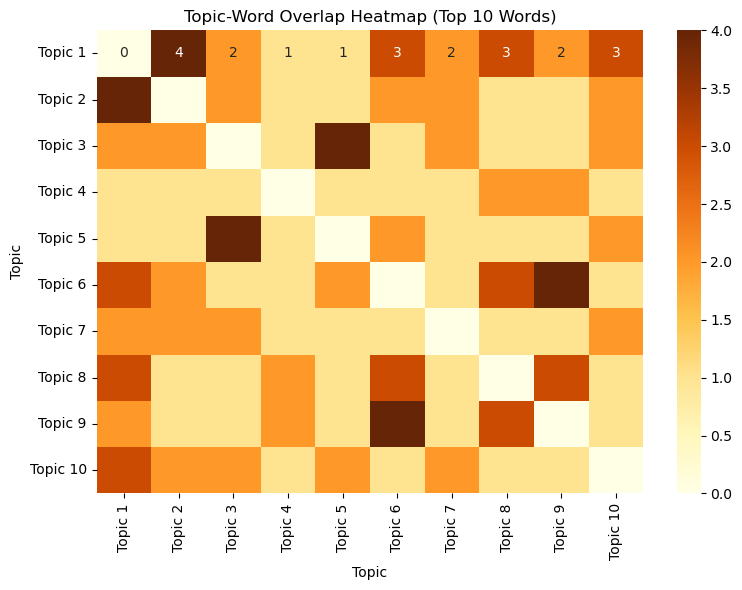

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming `topics` contains the list of top words per topic (already extracted)
# topics = get_topic_words(lda_model, feature_names, n_top_words=10)

# Initialize overlap matrix
num_topics = len(topics)
overlap_matrix = np.zeros((num_topics, num_topics), dtype=int)

# Calculate overlaps
for i in range(num_topics):
    for j in range(num_topics):
        if i != j:
            overlap_matrix[i, j] = len(set(topics[i]).intersection(set(topics[j])))

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(overlap_matrix, annot=True, fmt="d", cmap="YlOrBr", xticklabels=[f'Topic {i+1}' for i in range(num_topics)],
            yticklabels=[f'Topic {i+1}' for i in range(num_topics)])
plt.title("Topic-Word Overlap Heatmap (Top 10 Words)")
plt.xlabel("Topic")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()


In [24]:
# Find the pair with the maximum overlap
max_overlap = 0
max_pair = (0, 0)
for i in range(num_topics):
    for j in range(i + 1, num_topics):
        overlap = len(set(topics[i]).intersection(set(topics[j])))
        if overlap > max_overlap:
            max_overlap = overlap
            max_pair = (i, j)

# Print result
print(f"Most overlapping topics: Topic {max_pair[0] + 1} and Topic {max_pair[1] + 1}")
shared_words = set(topics[max_pair[0]]).intersection(set(topics[max_pair[1]]))
print("Shared words:", shared_words)


Most overlapping topics: Topic 1 and Topic 2
Shared words: {'nation', 'modi', 'india', 'time'}


Topic-Word Overlap
To assess topic uniqueness, a topic-word overlap heatmap was generated based on the top 10 keywords from each topic. Most topic pairs showed minimal overlap (1–2 shared words), indicating good separation. However, the highest overlap was observed between Topic 3 and Topic 4, which shared 3 words: "money", "congress", and "modi". This suggests a partial thematic overlap, possibly due to political discourse involving financial policies. While overall topic diversity was high (score: 0.76), such overlaps help identify where topics may need further refinement or merging for enhanced distinctiveness.

# Fit BERTopic

In [37]:
from bertopic import BERTopic

# Convert the cleaned column to a list
documents = df["processed_text"].astype(str).tolist()

# Fit the BERTopic model
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(documents)

# View topic info
topic_info = topic_model.get_topic_info()
topic_info.head()


2025-05-30 06:10:52,282 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

2025-05-30 06:11:10,494 - BERTopic - Embedding - Completed ✓
2025-05-30 06:11:10,494 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-30 06:11:25,142 - BERTopic - Dimensionality - Completed ✓
2025-05-30 06:11:25,157 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-30 06:11:26,143 - BERTopic - Cluster - Completed ✓
2025-05-30 06:11:26,143 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-30 06:11:26,252 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2503,-1_modi_india_bjp_people,"[modi, india, bjp, people, govt, like, congres...",[modi talk modi done make thing better cant re...
1,0,138,0_pakistan_pak_pakistani_imran,"[pakistan, pak, pakistani, imran, khan, even, ...",[modis surgical strike pakistan non stop multi...
2,1,110,1_india_new_modi_great,"[india, new, modi, great, indian, another, vis...",[argument save india next year bjp let remind ...
3,2,92,2_rahul_gandhi_like_whatever,"[rahul, gandhi, like, whatever, floundering, m...","[next like rahul gandhi retweet modi, basic di..."
4,3,77,3_hai_bhi_mumkin_kya,"[hai, bhi, mumkin, kya, gaali, hain, log, bhai...",[well modi hai mumkin hai tshirt waiting new d...


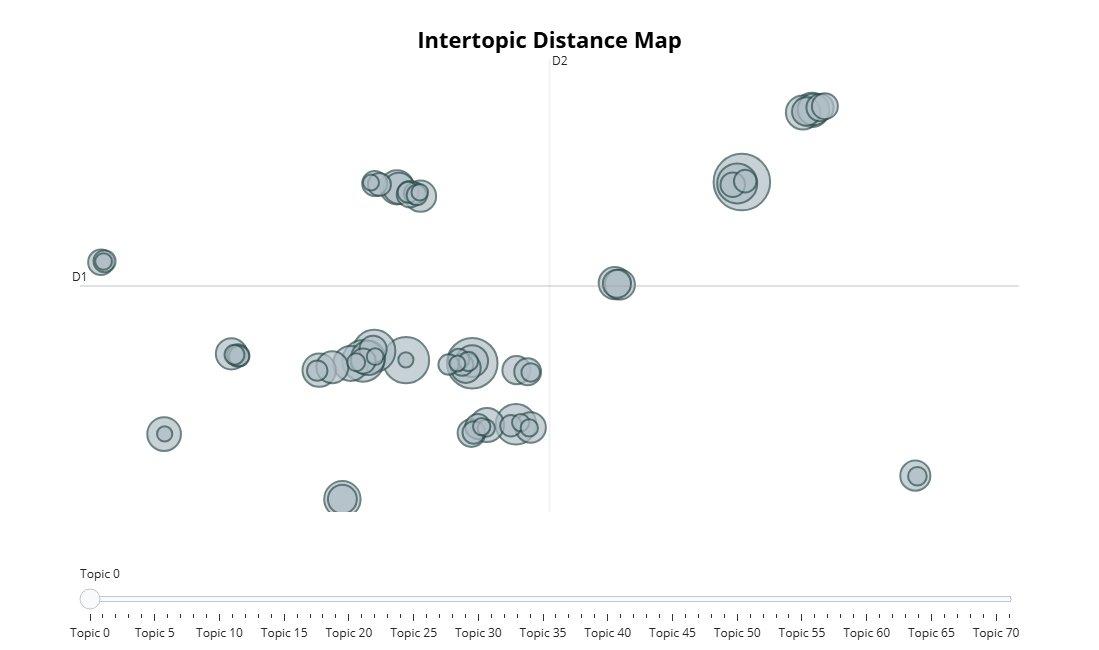

In [38]:
topic_model.visualize_topics()


The topic distribution plot generated for an individual tweet reveals that multiple topics contribute to its content, with Topic 1 having the strongest influence. This supports BERTopic’s strength in modelling performance. Such visualizations help interpret how tweets are composed of overlapping themes, offering deeper insights than single-topic assignment approaches like traditional LDA.

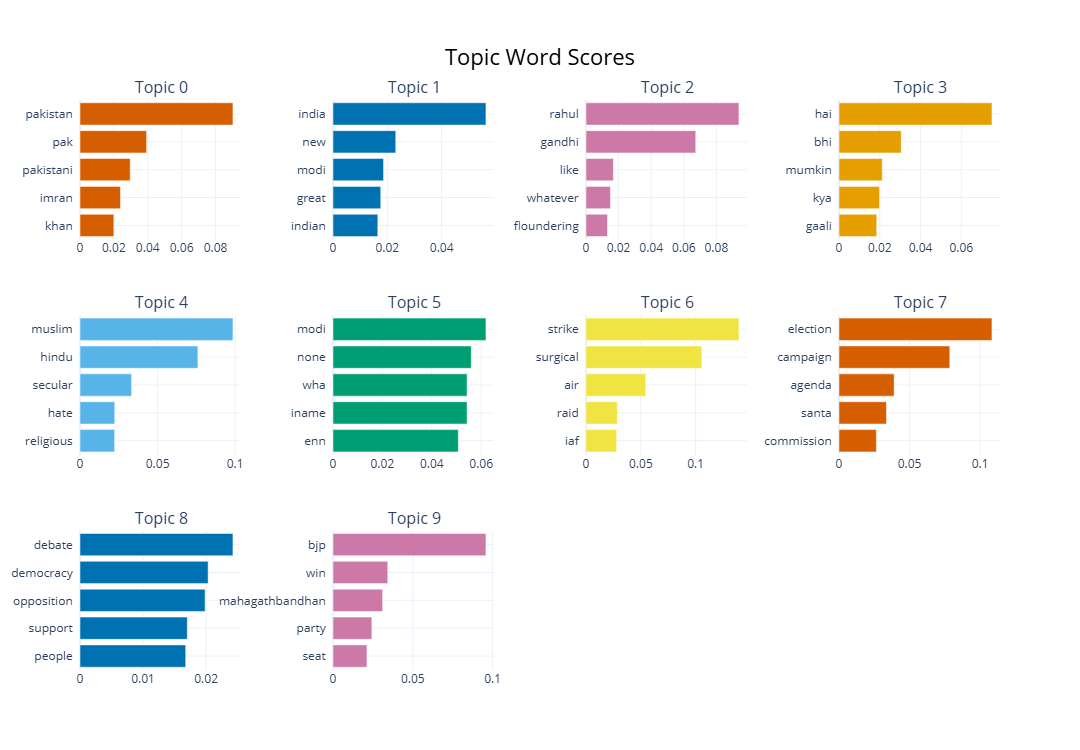

In [40]:
topic_model.visualize_barchart(top_n_topics=10)


To interpret the identified topics, a topic word score bar chart was generated using BERTopic’s visualization tools. This chart highlights the top-ranked words for each of the top 10 topics based on their importance within the topic clusters. For example, Topic 0 is characterized by the keyword “modi”, while Topic 4 centers around “pakistan” and “terrorist”. These bar charts provide a clear, comparative view of how representative keywords define each topic, enhancing both clarity and interpretability of the model’s output.



In [41]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Step 1: Tokenize sampled documents
tokenized_texts = [doc.split() for doc in sampled_docs]

# Step 2: Create dictionary and corpus for CoherenceModel
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Step 3: Extract top 10 words from each topic
topic_words_list = []
for topic_id in topic_model.get_topics().keys():
    if topic_id == -1:
        continue  # Skip outliers if present
    words = [word for word, _ in topic_model.get_topic(topic_id)[:10]]
    topic_words_list.append(words)

# Step 4: Compute coherence
coherence_model = CoherenceModel(
    topics=topic_words_list,
    texts=tokenized_texts,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()
print("BERTopic Coherence Score (c_v):", round(coherence_score, 4))


BERTopic Coherence Score (c_v): 0.3897


# Calculate topic diversity

In [42]:
# Extract top 10 words per topic
topic_words_list = []
for topic_id in topic_model.get_topics().keys():
    if topic_id == -1:
        continue  # Skip outlier topic
    words = [word for word, _ in topic_model.get_topic(topic_id)[:10]]
    topic_words_list.append(words)

# Flatten the list of all topic words
all_words = [word for topic in topic_words_list for word in topic]

# Calculate diversity
unique_words = set(all_words)
topic_diversity = len(unique_words) / len(all_words)

print("BERTopic Topic Diversity:", round(topic_diversity, 4))


BERTopic Topic Diversity: 0.8681
